In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [9]:
# Load TSV file
df = pd.read_csv("runups-2025-05-02_14-21-01_-0600.tsv", sep="\t")

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Filter for Alaska, Hawaii, Chile
df_ak = df[(df['Country'] == 'USA') & (df['Area'] == 'AK')].copy()
df_hi = df[(df['Country'] == 'USA') & (df['Area'] == 'HI')].copy()
df_cl = df[df['Country'] == 'CHILE'].copy()

# Add region labels
df_ak['Region'] = 'Alaska'
df_hi['Region'] = 'Hawaii'
df_cl['Region'] = 'Chile'

# Combine into one DataFrame
df_regions = pd.concat([df_ak, df_hi, df_cl], ignore_index=True)

# Select key columns
cols = [
    'Region', 'Location Name', 'Latitude', 'Longitude',
    'Distance From Source (km)', 'Travel Hours', 'Travel Minutes',
    'Max Water Height (m)', 'Max Inundation Distance (m)',
    'Deaths', 'Injuries', 'Damage $Mil'
]

df_filtered = df_regions[cols]


In [10]:
# Descriptive stats per region
summary_stats = df_filtered.groupby("Region")[[
    'Max Water Height (m)', 'Max Inundation Distance (m)',
    'Distance From Source (km)', 'Travel Hours', 'Travel Minutes',
    'Deaths', 'Injuries', 'Damage $Mil'
]].agg(['count', 'mean', 'max', 'min'])

summary_stats

Max Water Height (m)                         \
                      count      mean    max   min   
Region                                               
Alaska                   15  0.833333   2.29  0.05   
Chile                    28  6.335000  25.00  0.23   
Hawaii                  289  2.761453  10.70  0.30   

       Max Inundation Distance (m)                         \
                             count    mean     max    min   
Region                                                      
Alaska                           0     NaN     NaN    NaN   
Chile                            3  1148.8  3000.0  222.4   
Hawaii                           2   472.0   762.0  182.0   

       Distance From Source (km)                ...  Deaths       Injuries  \
                           count          mean  ...     max   min    count   
Region                                          ...                          
Alaska                        19  12678.671718  ...     NaN   NaN        0   
Chile                         32    626.813086  ...  2000.0   3.0        0   
Hawaii                       289  10897.412919  ...    61.0  61.0        1   

                         Damage $Mil                             
        mean   max   min       count        mean    max     min  
Region                                                           
Alaska   NaN   NaN   NaN           0         NaN    NaN     NaN  
Chile    NaN   NaN   NaN           1  550.000000  550.0  550.00  
Hawaii  43.0  43.0  43.0           3    8.083333   23.5    0.25  

[3 rows x 32 columns]

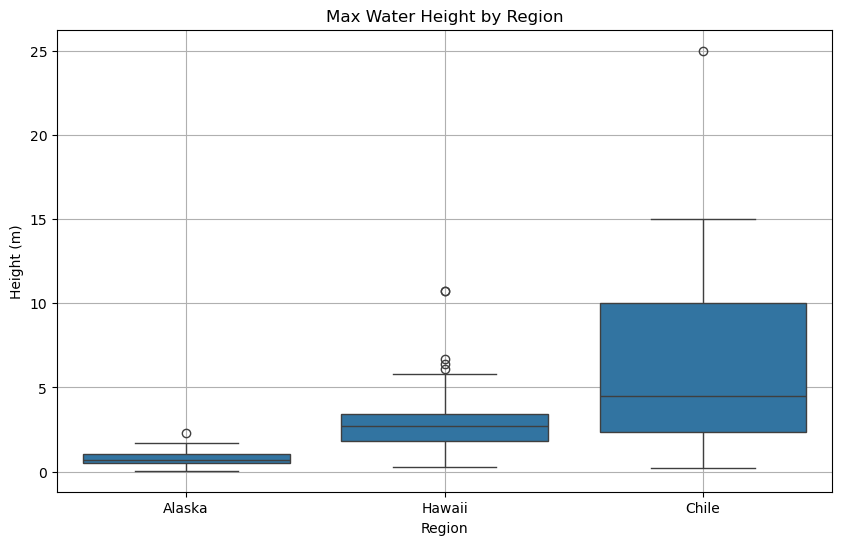

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Max Water Height (m)', data=df_filtered)
plt.title("Max Water Height by Region")
plt.ylabel("Height (m)")
plt.grid(True)
plt.show()

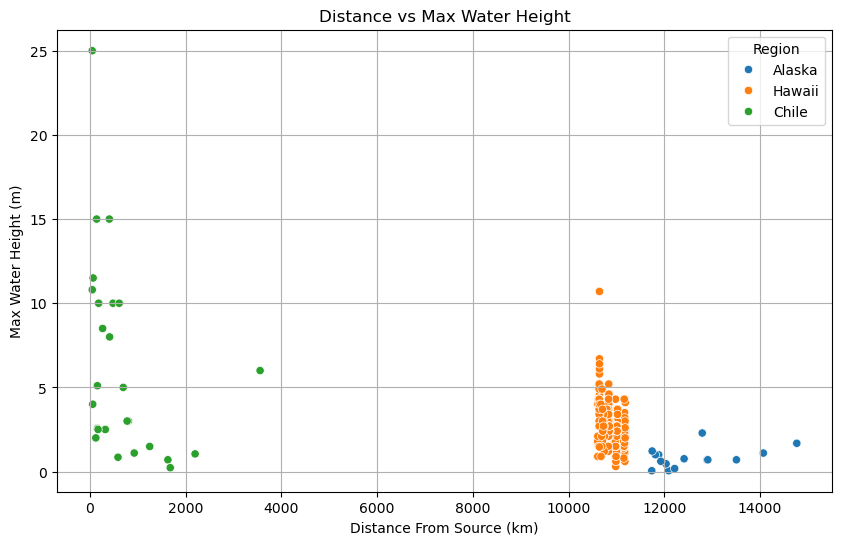

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Distance From Source (km)', y='Max Water Height (m)', hue='Region')
plt.title("Distance vs Max Water Height")
plt.grid(True)
plt.show()

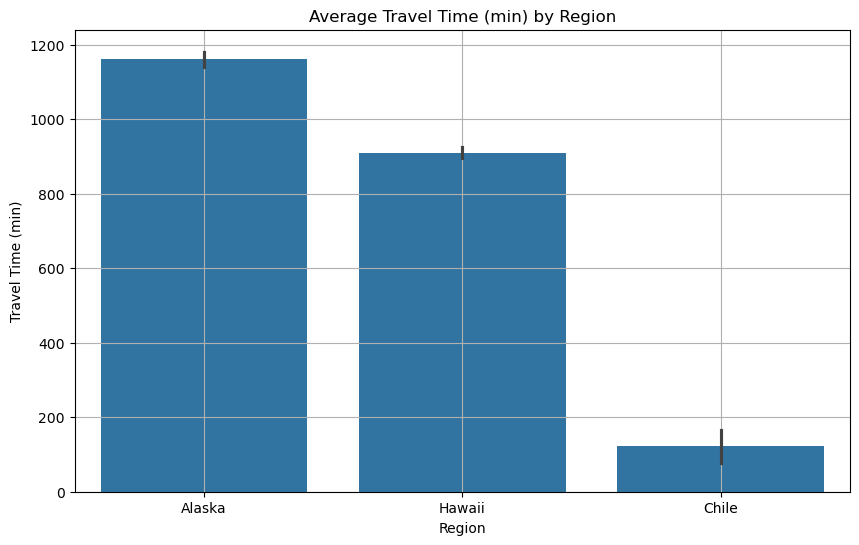

In [13]:
# Make an explicit copy to avoid SettingWithCopyWarning
df_filtered = df_regions[[
    'Region', 'Location Name', 'Latitude', 'Longitude',
    'Distance From Source (km)', 'Travel Hours', 'Travel Minutes',
    'Max Water Height (m)', 'Max Inundation Distance (m)',
    'Deaths', 'Injuries', 'Damage $Mil'
]].copy()

# Safely create a new column using .loc
df_filtered.loc[:, 'Travel Time (min)'] = (
    df_filtered['Travel Hours'] * 60 + df_filtered['Travel Minutes']
)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='Region', y='Travel Time (min)', estimator='mean')
plt.title("Average Travel Time (min) by Region")
plt.grid(True)
plt.show()


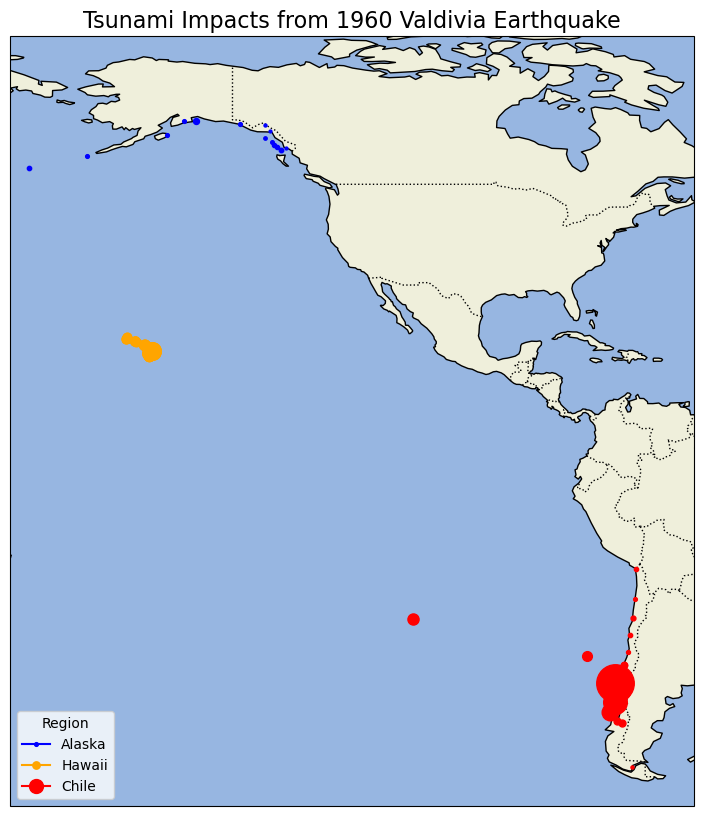

In [15]:
map_df = df_filtered.dropna(subset=['Latitude', 'Longitude', 'Max Water Height (m)'])

region_colors = {
    'Chile': 'red',
    'Hawaii': 'orange',
    'Alaska': 'blue'
}

plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Tsunami Impacts from 1960 Valdivia Earthquake", fontsize=16)

ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Adjust map extent: show more of the Northern Hemisphere
ax.set_extent([-180, -60, -60, 75], crs=ccrs.PlateCarree())

# Plot points with smaller markers
for _, row in map_df.iterrows():
    ax.plot(
        row['Longitude'], row['Latitude'],
        marker='o',
        markersize=2 + row['Max Water Height (m)'],
        color=region_colors.get(row['Region'], 'gray'),
        transform=ccrs.PlateCarree(),
        label=row['Region'] if row['Region'] not in ax.get_legend_handles_labels()[1] else ""
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Region", loc='lower left')

plt.show()
